**1**

Download  the  code Autoencoder.ipynb.   You  will  want  to  copy  the  code  for  the  model definitions,  but  do  not  run  the  training!   (unless  you  have  a  GPU  and  want  to  play  with the models beyond the assignment) Download the pre-trained fully-connected layer models fcAE<dim>.pthand convolutional layer models convAE<dim>.pth, where<dim>is the code(z) dimension:  16, 32, or 128.

In [1]:
import torch
from torch.utils.data import DataLoader
from torchvision.datasets import FashionMNIST
import torchvision.utils as vutils
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

**Load training data and plot it**

Note how the data is loaded with train = True. You can load the test data in a similar fashion, just set train = False. Feel free to reuse my plot function!

Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw


Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw
Processing...
Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


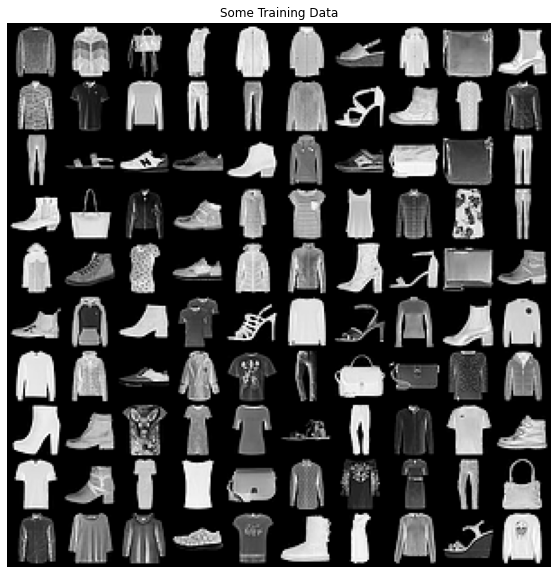

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

batch_size = 100
train_data = FashionMNIST("./data", train = True, download = True,
                          transform=transforms.ToTensor())
data_loader = DataLoader(train_data, batch_size = batch_size, shuffle = True)

width = 28
height = 28
input_size = width * height

def plot_images(batch, rows, cols, title = ""):
    plt.figure(figsize = (rows, cols))
    plt.axis("off")
    plt.title(title)
    plt.imshow(np.transpose(
        vutils.make_grid(batch[:(rows * cols)], nrow = rows, normalize = True).cpu(),
        (1, 2, 0)))
first_batch = next(iter(data_loader))
plot_images(first_batch[0], 10, 10, "Some Training Data")

**Define Models**

In [3]:
class FullyConnectedAutoencoder(nn.Module):
    def __init__(self, out_size):
        super(FullyConnectedAutoencoder, self).__init__()
        self.elayer1 = nn.Linear(input_size, 256)
        self.ebatch1 = nn.BatchNorm1d(256)
        self.elayer2 = nn.Linear(256, 128)
        self.ebatch2 = nn.BatchNorm1d(128)
        self.elayer3 = nn.Linear(128, out_size)

        self.dlayer1 = nn.Linear(out_size, 128)
        self.dbatch1 = nn.BatchNorm1d(128)
        self.dlayer2 = nn.Linear(128, 256)
        self.dbatch2 = nn.BatchNorm1d(256)
        self.dlayer3 = nn.Linear(256, input_size)
    
    def encoder(self, x):
        y1 = F.elu(self.ebatch1(self.elayer1(x)))
        y2 = F.elu(self.ebatch2(self.elayer2(y1)))
        z = F.elu(self.elayer3(y2))
        return z

    def decoder(self, z):
        y1 = F.elu(self.dbatch1(self.dlayer1(z)))
        y2 = F.elu(self.dbatch2(self.dlayer2(y1)))
        x = torch.sigmoid(self.dlayer3(y2))
        return x
        
    def forward(self, x):
        x = x.view(-1, input_size)
        z = self.encoder(x)
        y = self.decoder(z)
        y = y.view(-1, 1, width, height)
        return y

class ConvolutionalAutoencoder(nn.Module):
    def __init__(self, out_size):
        super(ConvolutionalAutoencoder, self).__init__()
        self.econv1 = nn.Conv2d(1, 32, kernel_size = 5, bias = False)
        self.ebatch1 = nn.BatchNorm2d(32)
        self.econv2 = nn.Conv2d(32, 8, kernel_size = 5, bias = False)
        self.ebatch2 = nn.BatchNorm2d(8)
        self.econv3 = nn.Conv2d(8, out_size, kernel_size = 20, bias = True)

        self.dconv1 = nn.ConvTranspose2d(out_size, 8, kernel_size = 20, bias = True)
        self.dbatch1 = nn.BatchNorm2d(8)
        self.dconv2 = nn.ConvTranspose2d(8, 32, kernel_size = 5, bias = False)
        self.dbatch2 = nn.BatchNorm2d(32)
        self.dconv3 = nn.ConvTranspose2d(32, 1, kernel_size = 5, bias = False)

    def encoder(self, x):
        # print("ECONV1", x.shape, self.econv1(x).shape)
        y1 = F.elu(self.ebatch1(self.econv1(x)))
        # print("ECONV2", y1.shape, self.econv2(y1).shape)
        y2 = F.elu(self.ebatch2(self.econv2(y1)))
        # print("ECONV3", y2.shape, self.econv3(y2).shape)
        z = F.elu(self.econv3(y2))
        return z

    def decoder(self, z):
        # print("DCONV1", z.shape, self.dconv1(z).shape)
        y1 = F.elu(self.dbatch1(self.dconv1(z)))
        # print("DCONV2", y1.shape, self.dconv2(y1).shape)
        y2 = F.elu(self.dbatch2(self.dconv2(y1)))
        # print("DCONV3", y2.shape, self.dconv3(y2).shape)
        x = torch.sigmoid(self.dconv3(y2))
        return x
     
    def forward(self, x):
        z = self.encoder(x)
        y = self.decoder(z)
        return y

In [4]:
from google.colab import files

# Convolutional Auto-Encoders
convAE16_pth = files.upload()
convAE32_pth = files.upload()
convAE128_pth = files.upload()

# Fully-Connected Auto-Encoders
fcAE16_pth = files.upload()
fcAE32_pth = files.upload()
fcAE128_pth = files.upload()

Saving convAE16.pth to convAE16.pth


Saving convAE32.pth to convAE32.pth


Saving convAE128.pth to convAE128.pth


Saving fcAE16.pth to fcAE16.pth


Saving fcAE32.pth to fcAE32.pth


Saving fcAE128.pth to fcAE128.pth


In [5]:
from io import BytesIO
import base64

# print(type(convAE16_pth))
# print(type(convAE16_pth["convAE16.pth"]))
# print( base64.b64decode(convAE16_pth["convAE16.pth"]))

In [6]:
convAE16 = ConvolutionalAutoencoder(16)
convAE32 = ConvolutionalAutoencoder(32)
convAE128 = ConvolutionalAutoencoder(128)

fcAE16 = FullyConnectedAutoencoder(16)
fcAE32 = FullyConnectedAutoencoder(32)
fcAE128 = FullyConnectedAutoencoder(128)

# The pth files are in bytes format
convAE16.load_state_dict(torch.load(BytesIO(convAE16_pth["convAE16.pth"])))
convAE32.load_state_dict(torch.load(BytesIO(convAE32_pth["convAE32.pth"])))    
convAE128.load_state_dict(torch.load(BytesIO(convAE128_pth["convAE128.pth"]))) 

fcAE16.load_state_dict(torch.load(BytesIO(fcAE16_pth["fcAE16.pth"])))
fcAE32.load_state_dict(torch.load(BytesIO(fcAE32_pth["fcAE32.pth"])))    
fcAE128.load_state_dict(torch.load(BytesIO(fcAE128_pth["fcAE128.pth"]))) 

<All keys matched successfully>

**2.** 

Plot  a  10×10  grid  of  images  from  the **test** set.   For  each  model,  plot  the  same  grid  ofthese images reconstructed by that model (encoded and decoded).  Qualitatively compare the various models.  What difference does convolutional vs.  fully-connected layers make?  What difference does the code dimension make?

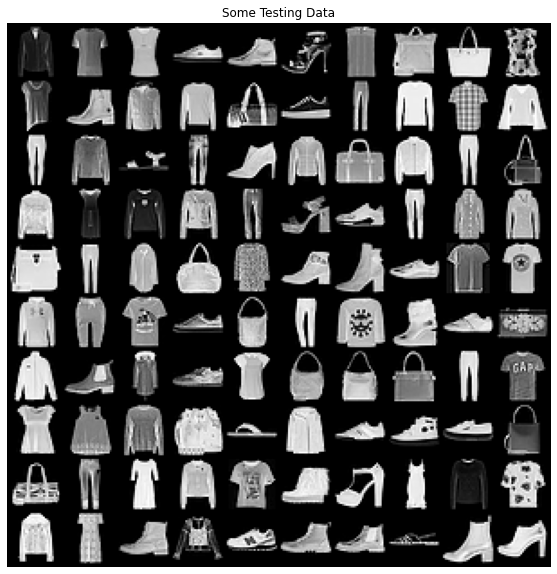

In [7]:
batch_size = 100
test_data = FashionMNIST("./data", train = False, download = True,
                          transform=transforms.ToTensor())
test_data_loader = DataLoader(test_data, batch_size = batch_size, shuffle = True)

width = 28
height = 28
input_size = width * height

def plot_images(batch, rows, cols, title = ""):
    plt.figure(figsize = (rows, cols))
    plt.axis("off")
    plt.title(title)
    plt.imshow(np.transpose(
        vutils.make_grid(batch[:(rows * cols)], nrow = rows, normalize = True).cpu(),
        (1, 2, 0)))

first_batch = next(iter(data_loader))
plot_images(first_batch[0], 10, 10, "Some Testing Data")

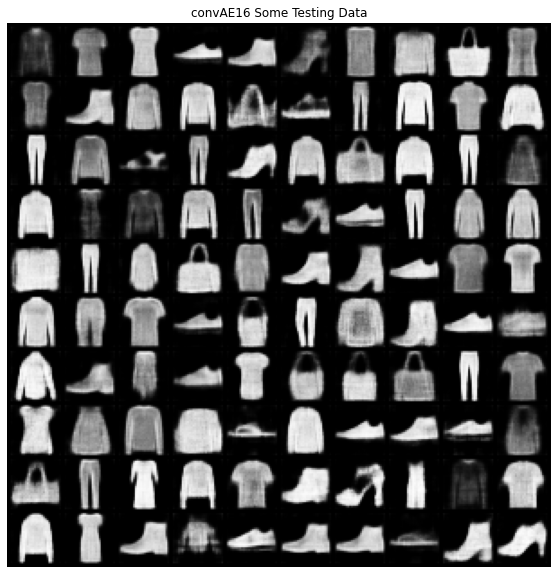

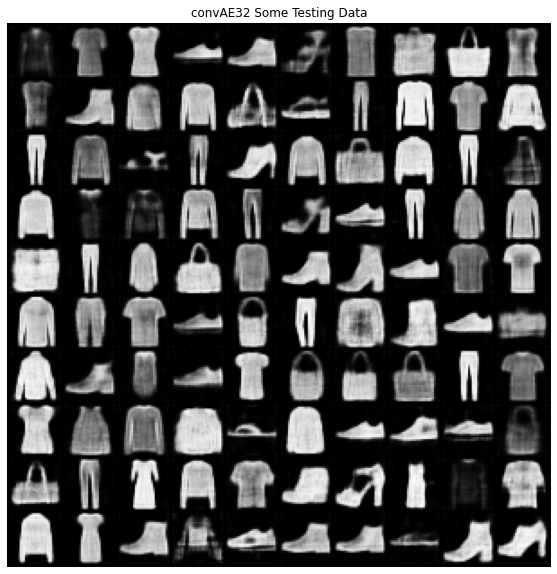

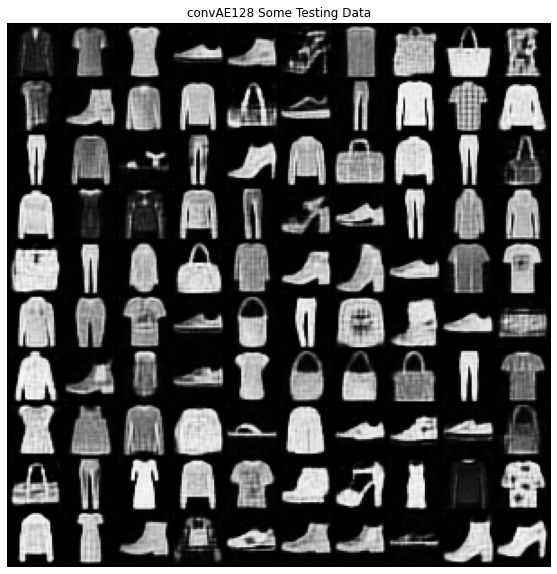

In [8]:
# Reconstruction With Convolutional AutoEncoder
convAE16.eval()
convAE32.eval()
convAE128.eval()

convAE16_recon = convAE16.forward(first_batch[0])
convAE32_recon = convAE32.forward(first_batch[0])
convAE128_recon = convAE128.forward(first_batch[0])

plot_images(convAE16_recon.detach(), 10, 10, "convAE16 Some Testing Data")
plot_images(convAE32_recon.detach(), 10, 10, "convAE32 Some Testing Data")
plot_images(convAE128_recon.detach(), 10, 10, "convAE128 Some Testing Data")

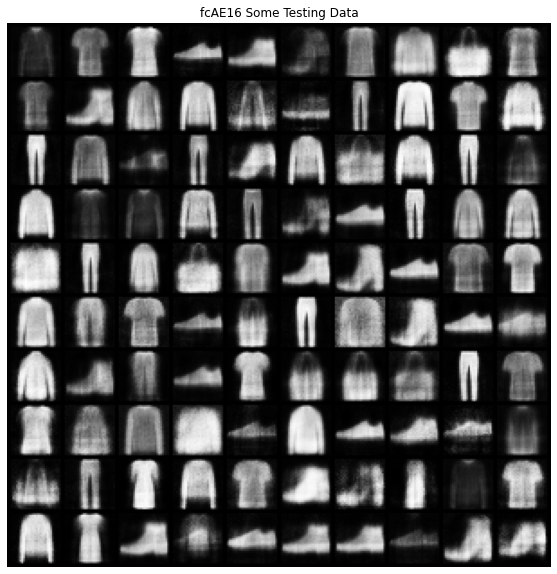

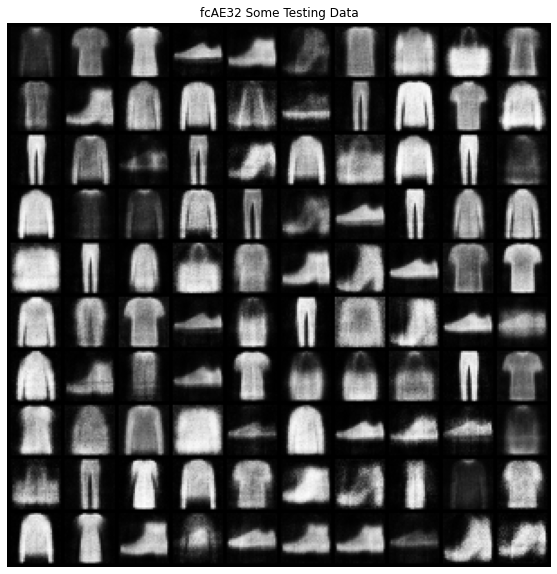

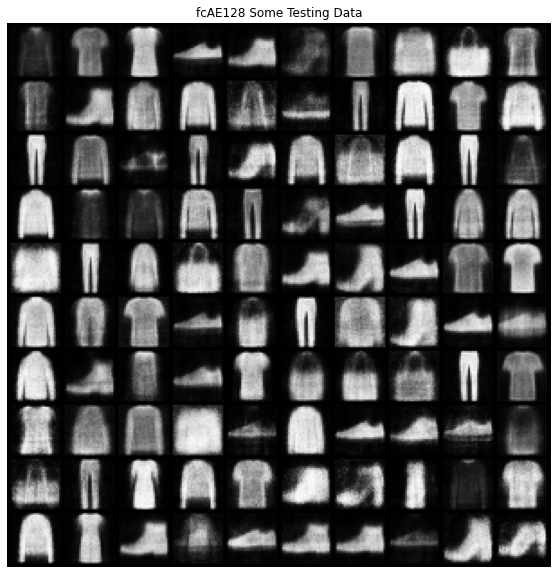

In [9]:
# Reconstruction With Fully-Connected AutoEncoder
fcAE16.eval()
fcAE32.eval()
fcAE128.eval()

fcAE16_recon = fcAE16.forward(first_batch[0])
fcAE32_recon = fcAE32.forward(first_batch[0])
fcAE128_recon = fcAE128.forward(first_batch[0])

plot_images(fcAE16_recon.detach(), 10, 10, "fcAE16 Some Testing Data")
plot_images(fcAE32_recon.detach(), 10, 10, "fcAE32 Some Testing Data")
plot_images(fcAE128_recon.detach(), 10, 10, "fcAE128 Some Testing Data")

Qualitatively speaking, it looks like convolutional auto-encoders generally give images that are more detailed than fully-connected versions. As code dimensions increase, the resulting image also becomes more detailed and "filled in". 

**3.**

 Compute a PCA of the **training** images.  Plot the same 10×10 images reconstructed from the first k principal component dimensions, where k= 16, 32, 128.  How does PCA reconstruction compare qualitatively to the autoencoders?  What does this tell you about the data manifold?

In [10]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

train_data = FashionMNIST("./data", train = True, download = True,
                          transform=transforms.ToTensor())
np_train_data = train_data.data.numpy()
print(np_train_data.shape)

(60000, 28, 28)


In [11]:
# Flatten the array
np_train_data_flat = np.reshape(np_train_data, (np_train_data.shape[0], np_train_data.shape[1] * np_train_data.shape[2]))

# Compute centered_data
np_train_data_bar = np_train_data_flat - np_train_data_flat.mean(axis=1, keepdims=True)

In [12]:
# Compute Covariance matrix
train_cov = np.cov(np_train_data_bar.T)

# Calculate Eigen Value and EigenVectors
EigVal,EigVec = np.linalg.eigh(train_cov)

In [13]:
# Ordering Eigen values and vectors
order = EigVal.argsort()[::-1]
EigVal = EigVal[order]
EigVec = EigVec[:,order]

#Projecting data on Eigen vector directions resulting to Principal Components 
PC = np.matmul(np_train_data_bar,EigVec)   #cross product

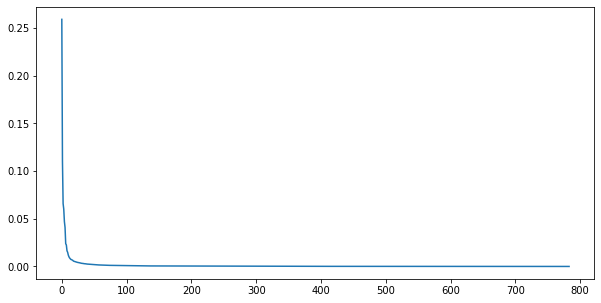

In [14]:
EigValDenom = sum(EigVal)
proportion_of_variance = [ EVal/EigValDenom for EVal in EigVal]
plt.figure(figsize=(10,5))

x = range(0, len(proportion_of_variance))
y = sorted(proportion_of_variance, reverse=True)
plt.plot(x, y)
plt.show()

In [15]:
# PCA Reconstruction
# train_data_recon = np.zeros((train_data.shape[0],train_data.shape[1],train_data.shape[2]))
np_train_data_recon = PC.reshape(np_train_data.shape[0], np_train_data.shape[1], np_train_data.shape[2])
np_train_data_recon.shape

(60000, 28, 28)

(60000, 16)
(60000, 32)
(60000, 128)


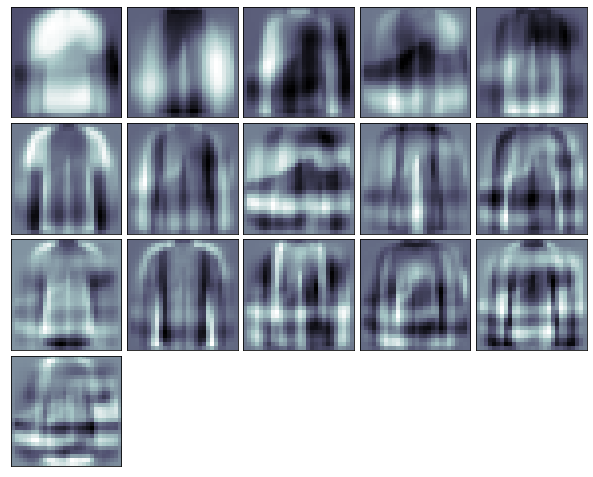

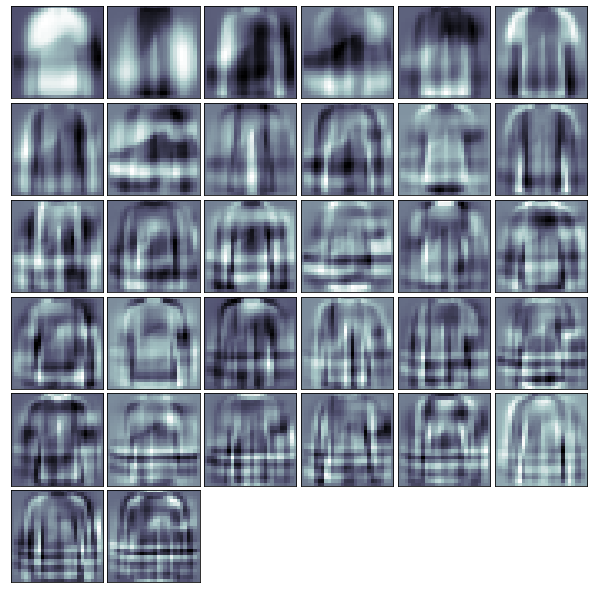

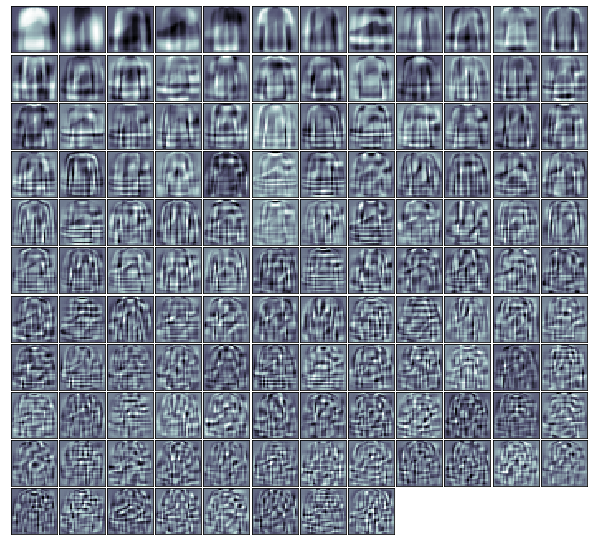

In [16]:
from sklearn.decomposition import PCA
X = np_train_data_flat
pca_16 = PCA(16)
pca_32 = PCA(32)
pca_128 = PCA(128)

# 16 K Componenets
X_proj_16 = pca_16.fit_transform(X)
print(X_proj_16.shape)

fig = plt.figure(figsize=(8,8))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

# plot the 16 k components
for i in range(16):
    ax = fig.add_subplot(5, 5, i+1, xticks=[], yticks=[])
    ax.imshow(np.reshape(pca_16.components_[i,:], (28,28)), cmap=plt.cm.bone, interpolation='nearest')


# 32 K Componenets
X_proj_32 = pca_32.fit_transform(X)
print(X_proj_32.shape)

fig = plt.figure(figsize=(8,8))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

for i in range(32):
    ax = fig.add_subplot(6, 6, i+1, xticks=[], yticks=[])
    ax.imshow(np.reshape(pca_32.components_[i,:], (28,28)), cmap=plt.cm.bone, interpolation='nearest')


# 128 K Componenets
X_proj_128 = pca_128.fit_transform(X)
print(X_proj_128.shape)

fig = plt.figure(figsize=(8,8))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

for i in range(128):
    ax = fig.add_subplot(12, 12, i+1, xticks=[], yticks=[])
    ax.imshow(np.reshape(pca_128.components_[i,:], (28,28)), cmap=plt.cm.bone, interpolation='nearest')

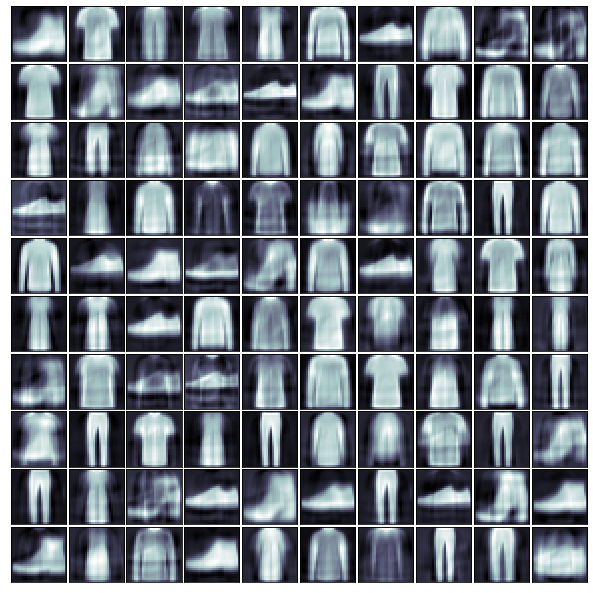

In [17]:
X_inv_proj_16 = pca_16.inverse_transform(X_proj_16) 
X_proj_img_16 = np.reshape(X_inv_proj_16,(60000,28,28))

X_inv_proj_32 = pca_32.inverse_transform(X_proj_32) 
X_proj_img_32 = np.reshape(X_inv_proj_32,(60000,28,28))

X_inv_proj_128 = pca_128.inverse_transform(X_proj_128) 
X_proj_img_128 = np.reshape(X_inv_proj_128,(60000,28,28))

#Setup a figure 8 inches by 8 inches
fig = plt.figure(figsize=(8,8))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

# 16 K Reconstruction
for i in range(100): 
    ax = fig.add_subplot(10, 10, i+1, xticks=[], yticks=[]) 
    ax.imshow(X_proj_img_16[i], cmap=plt.cm.bone, interpolation='nearest')  

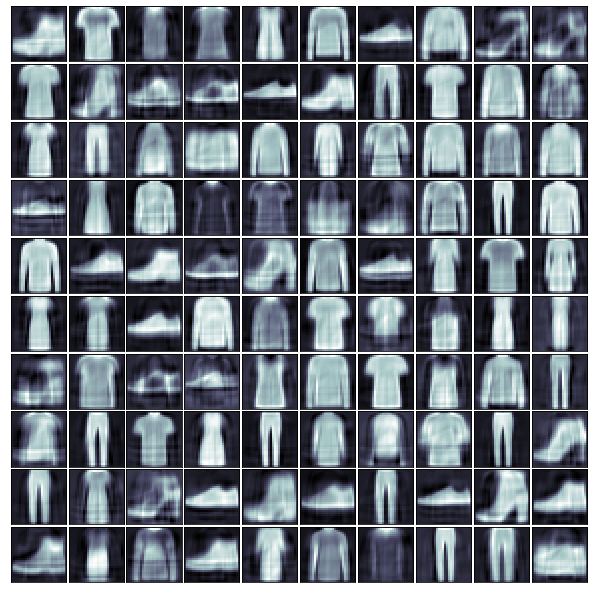

In [18]:
# 32 K Reconstruction
fig = plt.figure(figsize=(8,8))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

for i in range(100): 
    ax = fig.add_subplot(10, 10, i+1, xticks=[], yticks=[]) 
    ax.imshow(X_proj_img_32[i], cmap=plt.cm.bone, interpolation='nearest')

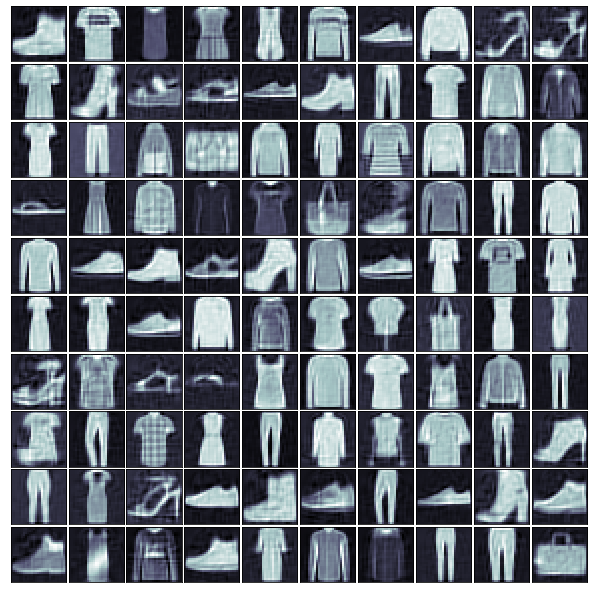

In [19]:
# 128 K Reconstruction
fig = plt.figure(figsize=(8,8))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

for i in range(100): 
    ax = fig.add_subplot(10, 10, i+1, xticks=[], yticks=[]) 
    ax.imshow(X_proj_img_128[i], cmap=plt.cm.bone, interpolation='nearest')

As we can see, PCA reconstruction achieves better results as k increases. Qualitatively, there is only really a slight difference between the reconstruction of PCA with k = 128 and autoencoders. This suggests the data manifold can be approximated really well using the linear method(PCA)

**4**

Pick two images from the test set that visually seem very different (e.g., from two different classes).  Plot a sequence of images that are along the linear path between these two images.Next,  for  each  autoencoder  model,  plot  a  sequence  of  images  that  are  interpolated  in  thelatent  code  space,  followed  by  application  of  the  decoder.   Try  all  these  plots  again  with two images that look visually similar.  Describe what you see comparing all of the different interpolations.

torch.Size([1, 1, 28, 28])
torch.Size([1, 1, 28, 28])
Classes:  tensor([9, 2, 1,  ..., 8, 1, 5])
tensor(1) tensor(1)


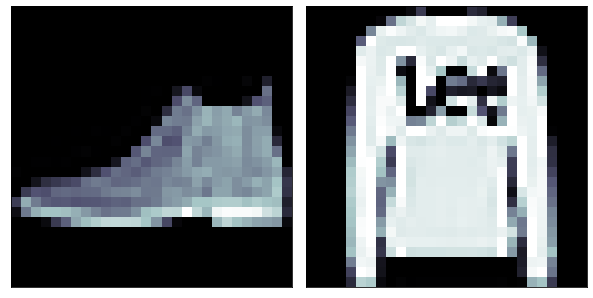

In [20]:
test_data = FashionMNIST("./data", train = False, download = True,
                          transform=transforms.ToTensor())
solo_test_data_loader = DataLoader(test_data, batch_size = 1)
print(next(iter(solo_test_data_loader))[0].shape)

test_data_loader = DataLoader(test_data, batch_size = 1)
print(next(iter(test_data_loader))[0].shape)

# Pick two objects in different clases
print("Classes: ", test_data.targets)
print(test_data.targets[2], test_data.targets[3])
test_data = test_data.data.numpy()

# Visualize these two objects
fig = plt.figure(figsize=(8,8))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)
for i in range(2): 
    ax = fig.add_subplot(2, 2, i+1, xticks=[], yticks=[]) 
    ax.imshow(test_data[i], cmap=plt.cm.bone, interpolation='nearest')

# Turns out index 2 and index 3 are both pants

We'll pick the first two images as they are in class 9 and class 2. The vector going from $v_1$ to $v_2$ is $d = v_1 - v_2$

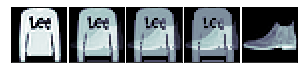

In [21]:
# Flatten the array
test_data_flat = np.reshape(test_data, (test_data.shape[0], test_data.shape[1] * test_data.shape[2]))

v_1 = test_data_flat[0]
v_2 = test_data_flat[1]
d = v_1 - v_2

# Visualize the linear path between the two images
fig = plt.figure(figsize=(8,8))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

scale = [0,0.25, 0.5, 0.75, 1]
for i in scale:
    d_multiple = i * d
    dv_2 = d_multiple + v_2 
    dv_2_image = np.reshape(dv_2, (28,28))

    ax = fig.add_subplot(10, 10, (i*(len(scale)-1))+1, xticks=[], yticks=[]) 
    ax.imshow(dv_2_image, cmap=plt.cm.bone, interpolation='nearest')

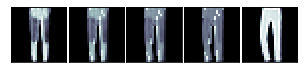

In [22]:
# Same thing as above but with similar class
v_1 = test_data_flat[2]
v_2 = test_data_flat[3]
d = v_1 - v_2

# Visualize the linear path between the two images
fig = plt.figure(figsize=(8,8))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

scale = [0,0.25, 0.5, 0.75, 1]
for i in scale:
    d_multiple = i * d
    dv_2 = d_multiple + v_2 
    dv_2_image = np.reshape(dv_2, (28,28))

    ax = fig.add_subplot(10, 10, (i*(len(scale)-1))+1, xticks=[], yticks=[]) 
    ax.imshow(dv_2_image, cmap=plt.cm.bone, interpolation='nearest')

In [23]:
import itertools

def interpolated_conv_img_seq(data_loader,ind_v1,ind_v2, model_list, scale=[0,0.25, 0.5, 0.75, 1]):
    iterator_data_loader_v1 = iter(test_data_loader)
    iterator_data_loader_v2 = iter(test_data_loader)

    v1_batch = next(itertools.islice(iterator_data_loader_v1, ind_v1, None))
    v2_batch = next(itertools.islice(iterator_data_loader_v2, ind_v2, None))
    print("v1_batch[0].shape: ", v1_batch[0].shape)
    for model in model_list:

        encoded_v1 = model.encoder(v1_batch[0])
        encoded_v2 = model.encoder(v2_batch[0])
        encoded_d = encoded_v1 - encoded_v2

        # Visualize sequence of images interpolated in the latent code space
        fig = plt.figure(figsize=(8,8))
        fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

        for i in scale:
            d_multiple = i * encoded_d
            dv_2 = d_multiple + encoded_v2

            # Decode this
            dv_2_decode = model.decoder(dv_2)
            # print("dv_2_decode.shap", dv_2_decode.shape)

            # Make sure you remove gradients via .detach() before converting to numpy
            dv_2_image = np.reshape(dv_2_decode.detach().numpy(), (28,28))

            ax = fig.add_subplot(10, 10, (i*(len(scale)-1))+1, xticks=[], yticks=[]) 
            ax.imshow(dv_2_image, cmap=plt.cm.bone, interpolation='nearest')

convAE Models.
v1_batch[0].shape:  torch.Size([1, 1, 28, 28])


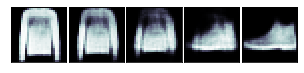

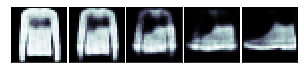

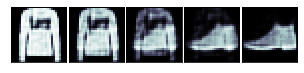

In [24]:
print("convAE Models.")
interpolated_conv_img_seq(test_data_loader, 0, 1, [convAE16, convAE32, convAE128])
# top row is 16, sec row is 32, last row is 128

convAE Models.
v1_batch[0].shape:  torch.Size([1, 1, 28, 28])


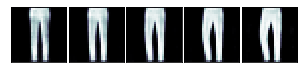

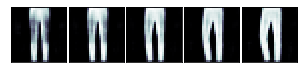

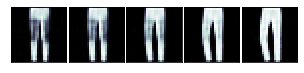

In [25]:
print("convAE Models.")
interpolated_conv_img_seq(solo_test_data_loader, 2, 3, [convAE16, convAE32, convAE128])
# top row is 16, sec row is 32, last row is 128

In [26]:
import itertools

def interpolated_fc_img_seq(data_loader,ind_v1,ind_v2, model_list, scale=[0,0.25, 0.5, 0.75, 1]):
    iterator_data_loader_v1 = iter(test_data_loader)
    iterator_data_loader_v2 = iter(test_data_loader)

    v1_batch = next(itertools.islice(iterator_data_loader_v1, ind_v1, None))
    v2_batch = next(itertools.islice(iterator_data_loader_v2, ind_v2, None))
    
    v1 = np.reshape(v1_batch[0], (1,784))
    v2 = np.reshape(v2_batch[0], (1,784))
    # print(v1.shape)
    # print(v2.shape)
    for model in model_list:

        encoded_v1 = model.encoder(v1)
        encoded_v2 = model.encoder(v2)
        encoded_d = encoded_v1 - encoded_v2

        # Visualize sequence of images interpolated in the latent code space
        fig = plt.figure(figsize=(8,8))
        fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

        for i in scale:
            d_multiple = i * encoded_d
            dv_2 = d_multiple + encoded_v2

            # Decode this
            dv_2_decode = model.decoder(dv_2)

            # Make sure you remove gradients via .detach() before converting to numpy
            dv_2_image = np.reshape(dv_2_decode.detach().numpy(), (28,28))

            ax = fig.add_subplot(10, 10, (i*(len(scale)-1))+1, xticks=[], yticks=[]) 
            ax.imshow(dv_2_image, cmap=plt.cm.bone, interpolation='nearest')

fcAE Models.


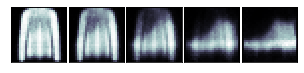

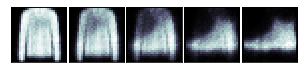

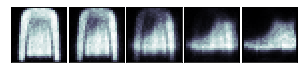

In [27]:
print("fcAE Models.")
interpolated_fc_img_seq(solo_test_data_loader, 0, 1, [fcAE16, fcAE32, fcAE128])

# top row is 16, sec row is 32, last row is 128

fcAE Models.


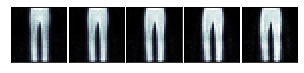

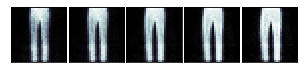

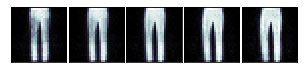

In [28]:
 print("fcAE Models.")
interpolated_fc_img_seq(solo_test_data_loader, 2, 3, [fcAE16, fcAE32, fcAE128])

# top row is 16, sec row is 32, last row is 128

Qualitatively, when seeing the transition between similar classes(pants to pants), the changes are very gradual and smooth. In fact, I personally think fcAE has a smoother transition. However, I think it's because the fcAE model captures less detail in general compared to the convAE. This is further seen when the model has less code dimensions. Looking at simply the leftmost image for fcAE16, fcAE32, fcAE128, we find that fcAE128 indeed has a more detailed output.

When looking at transition between different classes(pants to shoes), the fcAE models clearly can see a shoe in the middle transition image for all code dimensions. However, for the convAE models, you can argue that that only really occurs for the 128 code dimension model.

**5a**


For convAE16,
* econv1: a=1x28x28, b=1x32x((28-5)+1)x((28-5)+1)=32x24x24
* econv2: a=32x24x24, b=8x((24-5)+1)x((24-5)+1)=8x20x20
* econv3: a=8x20x20, b=16x((20-20)+1)x((20-20)+1)=16x1x1
* dconv1: a=16x1x1, b=8x20x20
* dconv2: a=8x20x20, b=32x24x24
* dconv3: a=32x24x24, b=1x28x28


For convAE32,
* econv1: a=1x28x28, b=32x24x24
* econv2: a=32x24x24, b8x20x20
* econv3: a=8x20x20, b=32x1x1
* dconv1: a=32x1x1, b=8x20x20
* dconv2: a=8x20x20, b=32x24x24
* dconv3: a=32x24x24, b=1x28x28

For convAE128,
* econv1: a=1x28x28, b=32x24x24
* econv2: a=32x24x24, b=8x20x20
* econv3: a=8x20x20, b=128x1x1
* dconv1: a=128x1x1, b=8x20x20
* dconv2: a=8x20x20, b=32x24x24
* dconv3: a=32x24x24, b=1x28x28



For fcAE16,
* elayer1: a=784, b=256
* elayer2: a=256, b=128
* elayer3: a=128, b=16
* dlayer1: a=16, b=128
* dlayer2: a=128, b=256
* dlayer3: a=256, b=784

For fcAE32,
* elayer1: a=784, b=256
* elayer2: a=256, b=128
* elayer3: a=128, b=32
* dlayer1: a=32, b=128
* dlayer2: a=128, b=256
* dlayer3: a=256, b=784

For fcAE128,
* elayer1: a=784, b=256
* elayer2: a=256, b=128
* elayer3: a=128, b=128
* dlayer1: a=128, b=128
* dlayer2: a=128, b=256
* dlayer3: a=256, b=784

**5b**

By looking only at the weights, convAE16, convAE32, convAE128 are not submersions as the dimensions of the weights do not decrease from input to output of econv1.

In [29]:
print("fcAE16")
print(torch.matrix_rank(fcAE16.elayer1.weight, tol=0.01))
print(torch.matrix_rank(fcAE16.elayer2.weight, tol=0.01))
print(torch.matrix_rank(fcAE16.elayer3.weight, tol=0.01))
print("\n")
print("fcAE32")
print(torch.matrix_rank(fcAE32.elayer1.weight, tol=0.01))
print(torch.matrix_rank(fcAE32.elayer2.weight, tol=0.01))
print(torch.matrix_rank(fcAE32.elayer3.weight, tol=0.01))
print("\n")
print("fcAE128")
print(torch.matrix_rank(fcAE128.elayer1.weight, tol=0.01))
print(torch.matrix_rank(fcAE128.elayer2.weight, tol=0.01))
print(torch.matrix_rank(fcAE128.elayer3.weight, tol=0.01))

fcAE16
tensor(256)
tensor(128)
tensor(16)


fcAE32
tensor(256)
tensor(128)
tensor(32)


fcAE128
tensor(256)
tensor(128)
tensor(126)


There is a rule of rank when multiplying matrices.

If 𝐴 is an 𝑚×𝑛 matrix and 𝐵 is a 𝑛×𝑟 matrix, prove that the rank of matrix 𝐴𝐵 is at most rank(𝐴).

As we can see for fcAE16 and fcAE32, we maintain full rank for all the matrices. This suggests that the jacobian for these two models also have full rank, therefore they are a submersion. However, we do not have the same for fcA128 which has 126 in the final layer(should be 128 if max rank). Therefore, fcAE128 is NOT a submersion

For all three convAE models, I believe the answer for all threee models is "cannot tell by weights by themselves". The reason is because the weights of the models are related to the filter. We cannot tell the jacobian's rank given these weight matrices or the rank of these weight matrices.

**5c**



In [30]:
print("fcAE16")
print(torch.matrix_rank(fcAE16.dlayer1.weight, tol=0.01))
print(torch.matrix_rank(fcAE16.dlayer2.weight, tol=0.01))
print(torch.matrix_rank(fcAE16.dlayer3.weight, tol=0.01))
print("\n")
print("fcAE32")
print(torch.matrix_rank(fcAE32.dlayer1.weight, tol=0.01))
print(torch.matrix_rank(fcAE32.dlayer2.weight, tol=0.01))
print(torch.matrix_rank(fcAE32.dlayer3.weight, tol=0.01))
print("\n")
print("fcAE128")
print(torch.matrix_rank(fcAE128.dlayer1.weight, tol=0.01))
print(torch.matrix_rank(fcAE128.dlayer2.weight, tol=0.01))
print(torch.matrix_rank(fcAE128.dlayer3.weight, tol=0.01))

fcAE16
tensor(16)
tensor(128)
tensor(256)


fcAE32
tensor(32)
tensor(128)
tensor(256)


fcAE128
tensor(125)
tensor(128)
tensor(256)


For fcAE16, fcAE32 we have max rank for each weight matrix. Therefore it suggest that these three model's decoders are an immersion. However, for  fcAE128, we do not have full rank for all matrices, thus it is not a immersion.

Similar to 5b, I believe we cannot tell from the weights alone that the convAE

**6**


In [31]:
import itertools
# Jacobians for decoders
def conv_jacobian_img_seq(data_loader,ind_v, model):
    iterator_data_loader_v = iter(test_data_loader)

    v_batch = next(itertools.islice(iterator_data_loader_v, ind_v, None))

    z = model.encoder(v_batch[0])
    # There are 28x28=784 dimensions in our image, we want to duplicate this so
    # we can pass the identity as the gradient param for .backward()
    print("Z shape: ", z.shape)
    # z_reshape = z.flatten().unsqueeze(dim = 0)
    # print("Z RESHAPE"z_reshape.shape)
    z_stack = z.repeat(784,1,1,1)
    print("Z_STACK shape: ", z_stack.shape)

    z_stack.retain_grad()
    x = model.decoder(z_stack)
    print("X shape: ", x.shape)
    reshape_x = x.reshape(784,784)
    print("New X shape: ", reshape_x.shape)
    reshape_x.backward(gradient=torch.eye(784))

    jacobian = z_stack.grad
    print("Jacobian Shape: ", jacobian.shape, "\n")

    return jacobian

import itertools

def fc_jacobian_img_seq(data_loader,ind_v, model):
    iterator_data_loader_v = iter(test_data_loader)

    v_batch = next(itertools.islice(iterator_data_loader_v, ind_v, None))

    v1 = np.reshape(v_batch[0], (1,784))

    z = model.encoder(v1)
    # There are 28x28=784 dimensions in our image, we want to duplicate this so
    # we can pass the identity as the gradient param for .backward()
    print("Z shape: ", z.shape)
    # z_reshape = z.flatten().unsqueeze(dim = 0)
    # print("Z RESHAPE"z_reshape.shape)
    z_stack = z.repeat(784,1)
    print("Z_STACK shape: ", z_stack.shape)

    z_stack.retain_grad()
    x = model.decoder(z_stack)
    print("X shape: ", x.shape)
    reshape_x = x.reshape(784,784)
    print("New X shape: ", reshape_x.shape)
    reshape_x.backward(gradient=torch.eye(784))

    jacobian = z_stack.grad
    print("Jacobian Shape: ", jacobian.shape, "\n")
    return jacobian

In [32]:
# conv16_jacob = enc_conv_jacobian_img_seq(test_data_loader, 0, convAE16)


In [33]:
conv16_jacob = conv_jacobian_img_seq(test_data_loader, 0, convAE16)
conv16_jacob = conv16_jacob.squeeze()

conv32_jacob = conv_jacobian_img_seq(test_data_loader, 0, convAE32)
conv32_jacob = conv32_jacob.squeeze()

conv128_jacob = conv_jacobian_img_seq(test_data_loader, 0, convAE128)
conv128_jacob = conv128_jacob.squeeze()

Z shape:  torch.Size([1, 16, 1, 1])
Z_STACK shape:  torch.Size([784, 16, 1, 1])
X shape:  torch.Size([784, 1, 28, 28])
New X shape:  torch.Size([784, 784])
Jacobian Shape:  torch.Size([784, 16, 1, 1]) 

Z shape:  torch.Size([1, 32, 1, 1])
Z_STACK shape:  torch.Size([784, 32, 1, 1])
X shape:  torch.Size([784, 1, 28, 28])
New X shape:  torch.Size([784, 784])
Jacobian Shape:  torch.Size([784, 32, 1, 1]) 

Z shape:  torch.Size([1, 128, 1, 1])
Z_STACK shape:  torch.Size([784, 128, 1, 1])
X shape:  torch.Size([784, 1, 28, 28])
New X shape:  torch.Size([784, 784])
Jacobian Shape:  torch.Size([784, 128, 1, 1]) 



In [34]:
fc16_jacob = fc_jacobian_img_seq(test_data_loader, 0, fcAE16)
fc16_jacob = fc16_jacob.squeeze()

fc32_jacob = fc_jacobian_img_seq(test_data_loader, 0, fcAE32)
fc32_jacob = fc32_jacob.squeeze()

fc128_jacob = fc_jacobian_img_seq(test_data_loader, 0, fcAE128)
fc128_jacob = fc128_jacob.squeeze()

Z shape:  torch.Size([1, 16])
Z_STACK shape:  torch.Size([784, 16])
X shape:  torch.Size([784, 784])
New X shape:  torch.Size([784, 784])
Jacobian Shape:  torch.Size([784, 16]) 

Z shape:  torch.Size([1, 32])
Z_STACK shape:  torch.Size([784, 32])
X shape:  torch.Size([784, 784])
New X shape:  torch.Size([784, 784])
Jacobian Shape:  torch.Size([784, 32]) 

Z shape:  torch.Size([1, 128])
Z_STACK shape:  torch.Size([784, 128])
X shape:  torch.Size([784, 784])
New X shape:  torch.Size([784, 784])
Jacobian Shape:  torch.Size([784, 128]) 



In [35]:
def jacobian_analysis(jacobian):
    U, S, V = torch.svd(jacobian)
    print(U.shape, S.shape, V.shape)
    print(f"Max Singular Value: {torch.max(S)} Min Singular Values: {torch.min(S)}")

    print(f"RANK:{torch.matrix_rank(jacobian)} \n")

In [36]:
# covAE16
jacobian_analysis(conv16_jacob)
print("Full Rank. Therefore, this decoder is an immersion \n")

# covAE32
jacobian_analysis(conv32_jacob)
print("Full Rank. Therefore, this decoder is an immersion \n")

# covAE128
jacobian_analysis(conv128_jacob)
print("Full Rank. Therefore, this decoder is an immersion \n")

# fcAE16
jacobian_analysis(fc16_jacob)
print("Full Rank. Therefore, this decoder is an immersion \n")

# fcAE32
jacobian_analysis(fc32_jacob)
print("Full Rank. Therefore, this decoder is an immersion \n")

# fcAE128
jacobian_analysis(fc128_jacob)
print("NOT Full Rank. Therefore, this decoder is NOT an immersion \n")

torch.Size([784, 16]) torch.Size([16]) torch.Size([16, 16])
Max Singular Value: 7.407811641693115 Min Singular Values: 1.881029486656189
RANK:16 

Full Rank. Therefore, this decoder is an immersion 

torch.Size([784, 32]) torch.Size([32]) torch.Size([32, 32])
Max Singular Value: 5.556408882141113 Min Singular Values: 0.7475249767303467
RANK:32 

Full Rank. Therefore, this decoder is an immersion 

torch.Size([784, 128]) torch.Size([128]) torch.Size([128, 128])
Max Singular Value: 7.063755989074707 Min Singular Values: 0.29238423705101013
RANK:128 

Full Rank. Therefore, this decoder is an immersion 

torch.Size([784, 16]) torch.Size([16]) torch.Size([16, 16])
Max Singular Value: 12.283872604370117 Min Singular Values: 1.2961584329605103
RANK:16 

Full Rank. Therefore, this decoder is an immersion 

torch.Size([784, 32]) torch.Size([32]) torch.Size([32, 32])
Max Singular Value: 10.331706047058105 Min Singular Values: 0.45487868785858154
RANK:32 

Full Rank. Therefore, this decoder is an

From the jacobian matrixes, we can see that the convolutions are immersions as their jacobians all have full rank. However, the same can not be said for the fcAE models as only fcAE16, fcAE32 have full rank and as predicted earlier, are immersions. FcAE128 does not have full rank in the jacobian and thus is not an immersion.

**7**

In [37]:
np_conv16_jacob = conv16_jacob.detach().numpy()
np_conv32_jacob = conv32_jacob.detach().numpy()
np_conv128_jacob = conv128_jacob.detach().numpy()

np_fc16_jacob = fc16_jacob.detach().numpy()
np_fc32_jacob = fc32_jacob.detach().numpy()
np_fc128_jacob = fc128_jacob.detach().numpy()

#the tangent vectors corresponding  to  the  latent  coordinate  axes
def plot_tang_vectors_latent_coords(jacobian):
    print(jacobian.shape)
    print(jacobian.shape[0], type(jacobian.shape[0]))
    tang_vectors = jacobian.T.reshape(jacobian.shape[-1], int(np.sqrt(jacobian.shape[0])), int(np.sqrt(jacobian.shape[0])))

    fig = plt.figure(figsize=(8,8))
    fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

    for i in range(tang_vectors.shape[0]):
        ax = fig.add_subplot(12, 12, i+1, xticks=[], yticks=[]) 
        ax.imshow(tang_vectors[i], cmap=plt.cm.bone, interpolation='nearest')

(784, 16)
784 <class 'int'>


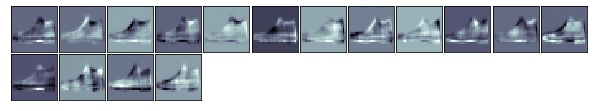

In [38]:
plot_tang_vectors_latent_coords(np_conv16_jacob)

(784, 32)
784 <class 'int'>


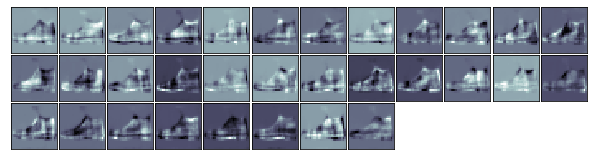

In [39]:
plot_tang_vectors_latent_coords(np_conv32_jacob)

(784, 128)
784 <class 'int'>


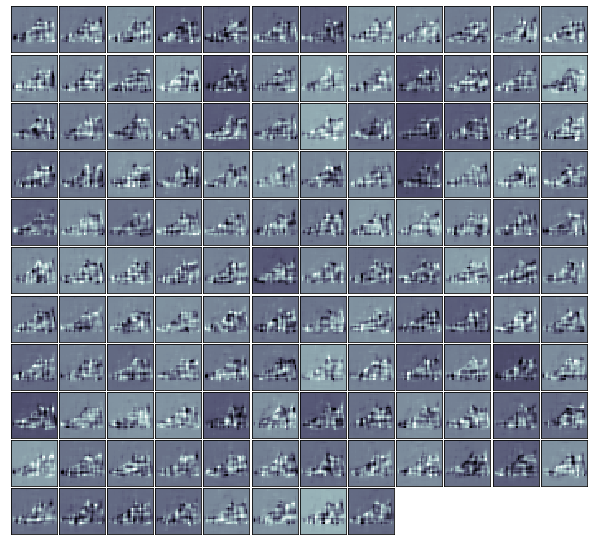

In [40]:
plot_tang_vectors_latent_coords(np_conv128_jacob)

(784, 16)
784 <class 'int'>


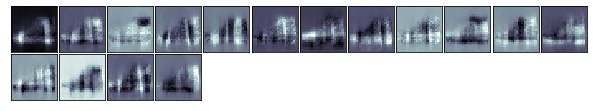

In [41]:
plot_tang_vectors_latent_coords(np_fc16_jacob)

(784, 32)
784 <class 'int'>


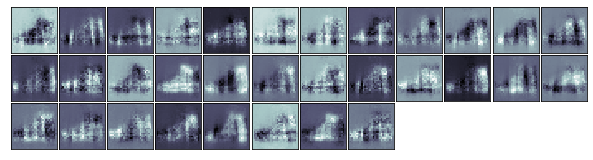

In [42]:
plot_tang_vectors_latent_coords(np_fc32_jacob)

(784, 128)
784 <class 'int'>


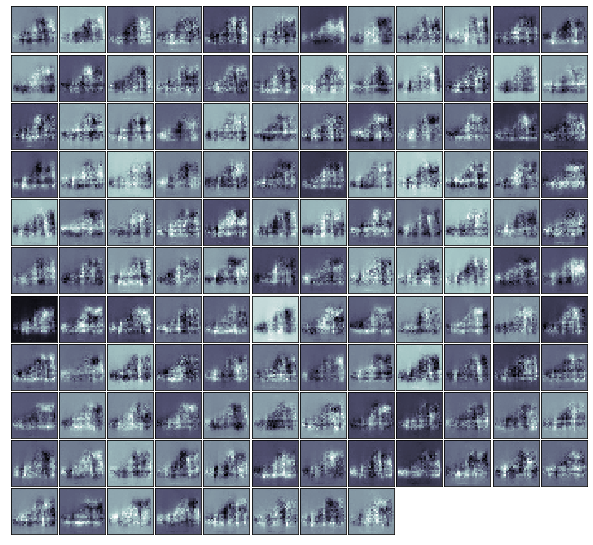

In [43]:
plot_tang_vectors_latent_coords(np_fc128_jacob)

In [44]:
from sklearn.decomposition import PCA

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

test_data = FashionMNIST("./data", train = False, download = True,
                          transform=transforms.ToTensor())

def plot_tang_vectors_pca(k, dataset):
    np_dataset = dataset.data.numpy()
    # Flatten the array
    np_dataset_flat = np.reshape(np_dataset, (np_dataset.shape[0], np_dataset.shape[1] * np_dataset.shape[2]))

    X = np_dataset_flat
    pca = PCA(k)

    X_proj = pca.fit_transform(X)
    print(X_proj.shape)

    fig = plt.figure(figsize=(8,8))
    fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

    for i in range(k):
        ax = fig.add_subplot(12, 12, i+1, xticks=[], yticks=[])
        ax.imshow(np.reshape(pca_128.components_[i,:], (28,28)), cmap=plt.cm.bone, interpolation='nearest')


(10000, 128)


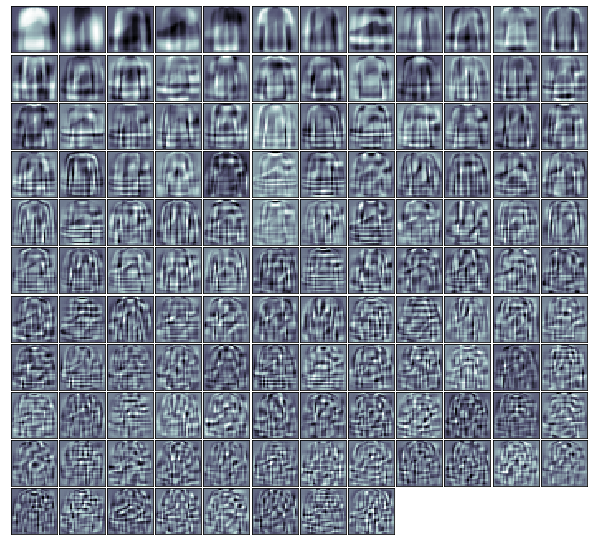

In [45]:
plot_tang_vectors_pca(128, test_data)

In the pca Plot, we are seeing what are the the tangent vectors corresponding to the top 128 componenets that carry most of the fMnist dataset's variance. We can see images of shirts, pants, and shoes, etc which makes perfect sense. There are also images in the pca plot which do not appear to look like regular clothes, which makes sense as our dataset does not have 128 different types of clothing classes.

The latent dimensions do make sense in terms of changes to the base images, as our example is a shoe, and you can clearly see each of the AutoEncoders visibly are containing shoes. We expectedly see more detailed shoes as we go from 16 to 32 to 128 for both fully connected and convolutional autoencoders.

**8**

In [46]:
def conv_jacobian_img_seq(data_loader,ind_v, model):
    iterator_data_loader_v = iter(test_data_loader)

    v_batch = next(itertools.islice(iterator_data_loader_v, ind_v, None))

    x = v_batch[0]
    x_stack = x.repeat(784,1,1,1)
    x_stack.retain_grad()

    z = model.encoder(x_stack)
    reshape_z = z.reshape(784,784)

    reshape_z.backward(gradient=torch.eye(784))

    jacobian = x_stack.grad
    return jacobian


def conv_jacobian_img_seq(data_loader,ind_v, model):
    iterator_data_loader_v = iter(test_data_loader)

    v_batch = next(itertools.islice(iterator_data_loader_v, ind_v, None))

    z = model.encoder(v_batch[0])
    # There are 28x28=784 dimensions in our image, we want to duplicate this so
    # we can pass the identity as the gradient param for .backward()
    print("Z shape: ", z.shape)
    # z_reshape = z.flatten().unsqueeze(dim = 0)
    # print("Z RESHAPE"z_reshape.shape)
    z_stack = z.repeat(784,1,1,1)
    print("Z_STACK shape: ", z_stack.shape)

    z_stack.retain_grad()
    x = model.decoder(z_stack)
    print("X shape: ", x.shape)
    reshape_x = x.reshape(784,784)
    print("New X shape: ", reshape_x.shape)
    reshape_x.backward(gradient=torch.eye(784))

    jacobian = z_stack.grad
    print("Jacobian Shape: ", jacobian.shape, "\n")

    return jacobian
    

In [47]:
conv16_jacob = conv_jacobian_img_seq(test_data_loader, 0, convAE16)
conv16_jacob = conv16_jacob.squeeze()

conv32_jacob = conv_jacobian_img_seq(test_data_loader, 0, convAE32)
conv32_jacob = conv32_jacob.squeeze()

conv128_jacob = conv_jacobian_img_seq(test_data_loader, 0, convAE128)
conv128_jacob = conv128_jacob.squeeze()

fc16_jacob = fc_jacobian_img_seq(test_data_loader, 0, fcAE16)
fc16_jacob = fc16_jacob.squeeze()

fc32_jacob = fc_jacobian_img_seq(test_data_loader, 0, fcAE32)
fc32_jacob = fc32_jacob.squeeze()

fc128_jacob = fc_jacobian_img_seq(test_data_loader, 0, fcAE128)
fc128_jacob = fc128_jacob.squeeze()

Z shape:  torch.Size([1, 16, 1, 1])
Z_STACK shape:  torch.Size([784, 16, 1, 1])
X shape:  torch.Size([784, 1, 28, 28])
New X shape:  torch.Size([784, 784])
Jacobian Shape:  torch.Size([784, 16, 1, 1]) 

Z shape:  torch.Size([1, 32, 1, 1])
Z_STACK shape:  torch.Size([784, 32, 1, 1])
X shape:  torch.Size([784, 1, 28, 28])
New X shape:  torch.Size([784, 784])
Jacobian Shape:  torch.Size([784, 32, 1, 1]) 

Z shape:  torch.Size([1, 128, 1, 1])
Z_STACK shape:  torch.Size([784, 128, 1, 1])
X shape:  torch.Size([784, 1, 28, 28])
New X shape:  torch.Size([784, 784])
Jacobian Shape:  torch.Size([784, 128, 1, 1]) 

Z shape:  torch.Size([1, 16])
Z_STACK shape:  torch.Size([784, 16])
X shape:  torch.Size([784, 784])
New X shape:  torch.Size([784, 784])
Jacobian Shape:  torch.Size([784, 16]) 

Z shape:  torch.Size([1, 32])
Z_STACK shape:  torch.Size([784, 32])
X shape:  torch.Size([784, 784])
New X shape:  torch.Size([784, 784])
Jacobian Shape:  torch.Size([784, 32]) 

Z shape:  torch.Size([1, 128])

Tangent vector of transformation can be aproximated with $\frac{I_{eps} - I_0}{eps}$ for some small eps > 0

In [48]:
def rotation_tangent_vector(data_loader, epsilon):
    # epsilon must be some small val > 0
    orig_img_batch = next(iter(test_data_loader))

    # orig_img = torch.reshape(orig_img_batch[0], (28,28))
    orig_img = orig_img_batch[0]

    # Approximate of the derivative of image rotated AND translated
    # test = transforms.functional.affine(orig_img, -epsilon, [2,2], 1, 0)
    rot_img = transforms.functional.rotate(orig_img, epsilon)
    I_epsilon = rot_img

    X = (I_epsilon - orig_img)/epsilon
    return X

def translationx_tangent_vector(data_loader, epsilon):
    # epsilon must be some small val > 0
    orig_img_batch = next(iter(test_data_loader))

    # orig_img = torch.reshape(orig_img_batch[0], (28,28))
    orig_img = orig_img_batch[0]

    # Approximate of the derivative of image rotated AND translated
    transx_img = transforms.functional.affine(orig_img, 0, [epsilon,0], 1, 0)
    I_epsilon = transx_img

    X = (I_epsilon - orig_img)/epsilon
    return X
    

def translationy_tangent_vector(data_loader, epsilon):
    # epsilon must be some small val > 0
    orig_img_batch = next(iter(test_data_loader))

    # orig_img = torch.reshape(orig_img_batch[0], (28,28))
    orig_img = orig_img_batch[0]

    # Approximate of the derivative of image rotated AND translated
    transy_img = transforms.functional.affine(orig_img, 0, [0,epsilon], 1, 0)
    I_epsilon = transy_img

    X = (I_epsilon - orig_img)/epsilon
    return X

In [49]:
def vector_proj(tangent_vector, tangent_space):
    U, S, V = torch.svd(tangent_space)
    # print(tangent_vector.shape, tangent_space.shape)
    # print(U.shape, S.shape, V.shape)
    proj_sum = torch.zeros(784)
    for i,x in enumerate(U.T):
        a = tangent_vector.flatten()
        b = x.float()
        # print(a.dtype, b.dtype)
        # print("Ashape ", a.shape, "Bshape ", b.shape)
        inner_product = torch.dot(a,b)
        b_norm = torch.linalg.norm(b)
        proj = (inner_product/(b_norm * b_norm)) * b
        # proj = (inner_product/(1)) * b

        proj_sum = proj_sum.add(proj)
    return proj_sum

def find_angle(projection, tangent_vector):
    tangent_vector = tangent_vector.flatten()

    # print(projection.shape, tangent_vector.shape)

    tang_norm = torch.linalg.norm(tangent_vector)
    proj_norm = torch.linalg.norm(projection)

    normalized_tang_vec = tangent_vector/tang_norm
    normalized_proj_vec = projection/proj_norm

    cos = torch.dot(projection/proj_norm, tangent_vector/tang_norm)
    # print("COS ", cos)
    # angle
    angle = torch.acos(cos)
    return torch.rad2deg(angle)

In [50]:
# Tangent Vector induced by rotation
rot_tangv = rotation_tangent_vector(solo_test_data_loader,3)

# Tangent Vector induced by X translation
transx_tangv = translationx_tangent_vector(solo_test_data_loader,2)

# Tangent Vector induced by Y translation
transy_tangv = translationy_tangent_vector(solo_test_data_loader,2)

**JACOBIAN**

In [51]:
# Checking to see of translations and rotations are in the tangent space
torch.set_printoptions(precision=10)
# ConvAE
print("convAE16")
rot_projection_16 = vector_proj(rot_tangv, conv16_jacob)
transx_projection_16 = vector_proj(transx_tangv, conv16_jacob)
transy_projection_16 = vector_proj(transy_tangv, conv16_jacob)


print("Rotation Angle: ", find_angle(rot_projection_16, rot_tangv))
print("TranslationX Angle: ", find_angle(transx_projection_16, transx_tangv))
print("TranslationY Angle: ", find_angle(transy_projection_16, transy_tangv))

print('\n')

# print("convAE32")
rot_projection_32 = vector_proj(rot_tangv, conv32_jacob)
transx_projection_32 = vector_proj(transx_tangv, conv32_jacob)
transy_projection_32 = vector_proj(transy_tangv, conv32_jacob)

print("Rotation Angle: ", find_angle(rot_projection_32, rot_tangv))
print("TranslationX Angle: ", find_angle(transx_projection_32, transx_tangv))
print("TranslationY Angle: ", find_angle(transy_projection_32, transy_tangv))
print('\n')

print("convAE128")
rot_projection_128 = vector_proj(rot_tangv, conv128_jacob)
transx_projection_128 = vector_proj(transx_tangv, conv128_jacob)
transy_projection_128 = vector_proj(transy_tangv, conv128_jacob)

print("Rotation Dist: ", find_angle(rot_projection_128, rot_tangv))
print("TranslationX Angle: ", find_angle(transx_projection_128, transx_tangv))
print("TranslationY Angle: ", find_angle(transy_projection_128, transy_tangv))

convAE16
Rotation Angle:  tensor(63.6711463928)
TranslationX Angle:  tensor(57.0680732727)
TranslationY Angle:  tensor(54.8563308716)


Rotation Angle:  tensor(52.7040557861)
TranslationX Angle:  tensor(46.2632293701)
TranslationY Angle:  tensor(51.6042709351)


convAE128
Rotation Dist:  tensor(35.8675651550)
TranslationX Angle:  tensor(34.8458251953)
TranslationY Angle:  tensor(36.4942703247)


In [52]:
# Checking to see of translations and rotations are in the tangent space
torch.set_printoptions(precision=10)

# fcAE
print("fcAE16")
rot_projection_16 = vector_proj(rot_tangv, fc16_jacob)
transx_projection_16 = vector_proj(transx_tangv, fc16_jacob)
transy_projection_16 = vector_proj(transy_tangv, fc16_jacob)

print("Rotation Angle: ", find_angle(rot_projection_16, rot_tangv.flatten()))
print("TranslationX Angle: ", find_angle(transx_projection_16, transx_tangv))
print("TranslationY Angle: ", find_angle(transy_projection_16, transy_tangv))

print('\n')

rot_projection_32 = vector_proj(rot_tangv, fc32_jacob)
transx_projection_32 = vector_proj(transx_tangv, fc32_jacob)
transy_projection_32 = vector_proj(transy_tangv, fc32_jacob)

print("fcAE32")
print("Rotation Angle: ", find_angle(rot_projection_32, rot_tangv))
print("TranslationX Angle: ", find_angle(transx_projection_32, transx_tangv))
print("TranslationY Angle: ", find_angle(transy_projection_32, transy_tangv))
print('\n')

print("fcAE128")
rot_projection_128 = vector_proj(rot_tangv, fc128_jacob)
transx_projection_128 = vector_proj(transx_tangv, fc128_jacob)
transy_projection_128 = vector_proj(transy_tangv, fc128_jacob)

print("Rotation Angle: ", find_angle(rot_projection_128, rot_tangv))
print("TranslationX Angle: ", find_angle(transx_projection_128, transx_tangv))
print("TranslationY Angle: ", find_angle(transy_projection_128, transy_tangv))
print('\n')

fcAE16
Rotation Angle:  tensor(73.9425735474)
TranslationX Angle:  tensor(70.3333740234)
TranslationY Angle:  tensor(45.1148681641)


fcAE32
Rotation Angle:  tensor(68.4979476929)
TranslationX Angle:  tensor(63.9056892395)
TranslationY Angle:  tensor(39.4009475708)


fcAE128
Rotation Angle:  tensor(49.9498558044)
TranslationX Angle:  tensor(48.0594978333)
TranslationY Angle:  tensor(32.0532302856)




**IMAGE OF PCA**

In [53]:
# Checking to see of translations and rotations are in the tangent space
torch.set_printoptions(precision=10)

# ConvAE
print("convAE16")
# pca_basis_16 = get_basis(torch.tensor(pca_16.components_).T).T    # transpose again because return U.
rot_projection_16 = vector_proj(rot_tangv, torch.tensor(pca_16.components_).T)
transx_projection_16 = vector_proj(transx_tangv, torch.tensor(pca_16.components_).T)
transy_projection_16 = vector_proj(transy_tangv, torch.tensor(pca_16.components_).T)


print("Rotation Angle: ", find_angle(rot_projection_16, rot_tangv))
print("TranslationX Angle: ", find_angle(transx_projection_16, transx_tangv))
print("TranslationY Angle: ", find_angle(transy_projection_16, transy_tangv))

print('\n')

print("convAE32")
rot_projection_32 = vector_proj(rot_tangv, torch.tensor(pca_32.components_).T)
transx_projection_32 = vector_proj(transx_tangv, torch.tensor(pca_32.components_).T)
transy_projection_32 = vector_proj(transy_tangv, torch.tensor(pca_32.components_).T)

print("Rotation Angle: ", find_angle(rot_projection_32, rot_tangv))
print("TranslationX Angle: ", find_angle(transx_projection_32, transx_tangv))
print("TranslationY Angle: ", find_angle(transy_projection_32, transy_tangv))
print('\n')

print("convAE128")
rot_projection_128 = vector_proj(rot_tangv, torch.tensor(pca_128.components_).T)
transx_projection_128 = vector_proj(transx_tangv, torch.tensor(pca_128.components_).T)
transy_projection_128 = vector_proj(transy_tangv, torch.tensor(pca_128.components_).T)

print("Rotation Dist: ", find_angle(rot_projection_128, rot_tangv))
print("TranslationX Angle: ", find_angle(transx_projection_128, transx_tangv))
print("TranslationY Angle: ", find_angle(transy_projection_128, transy_tangv))

convAE16
Rotation Angle:  tensor(79.6595764160)
TranslationX Angle:  tensor(71.1869659424)
TranslationY Angle:  tensor(46.2958793640)


convAE32
Rotation Angle:  tensor(74.5496063232)
TranslationX Angle:  tensor(62.8893356323)
TranslationY Angle:  tensor(37.4927177429)


convAE128
Rotation Dist:  tensor(53.0834732056)
TranslationX Angle:  tensor(41.0682373047)
TranslationY Angle:  tensor(21.6433105469)


In [54]:
# Checking to see of translations and rotations are in the tangent space
torch.set_printoptions(precision=10)

# fcAE
print("fcAE16")
rot_projection_16 = vector_proj(rot_tangv, torch.tensor(pca_16.components_).T)
transx_projection_16 = vector_proj(transx_tangv, torch.tensor(pca_16.components_).T)
transy_projection_16 = vector_proj(transy_tangv, torch.tensor(pca_16.components_).T)

print("Rotation Angle: ", find_angle(rot_projection_16, rot_tangv.flatten()))
print("TranslationX Angle: ", find_angle(transx_projection_16, transx_tangv))
print("TranslationY Angle: ", find_angle(transy_projection_16, transy_tangv))

print('\n')

rot_projection_32 = vector_proj(rot_tangv, torch.tensor(pca_32.components_).T)
transx_projection_32 = vector_proj(transx_tangv, torch.tensor(pca_32.components_).T)
transy_projection_32 = vector_proj(transy_tangv, torch.tensor(pca_32.components_).T)

print("fcAE32")
print("Rotation Angle: ", find_angle(rot_projection_32, rot_tangv))
print("TranslationX Angle: ", find_angle(transx_projection_32, transx_tangv))
print("TranslationY Angle: ", find_angle(transy_projection_32, transy_tangv))
print('\n')

print("fcAE128")
rot_projection_128 = vector_proj(rot_tangv, torch.tensor(pca_128.components_).T)
transx_projection_128 = vector_proj(transx_tangv,torch.tensor(pca_128.components_).T)
transy_projection_128 = vector_proj(transy_tangv, torch.tensor(pca_128.components_).T)

print("Rotation Angle: ", find_angle(rot_projection_128, rot_tangv))
print("TranslationX Angle: ", find_angle(transx_projection_128, transx_tangv))
print("TranslationY Angle: ", find_angle(transy_projection_128, transy_tangv))
print('\n')

fcAE16
Rotation Angle:  tensor(79.6595764160)
TranslationX Angle:  tensor(71.1869659424)
TranslationY Angle:  tensor(46.2958793640)


fcAE32
Rotation Angle:  tensor(74.5496063232)
TranslationX Angle:  tensor(62.8893356323)
TranslationY Angle:  tensor(37.4927177429)


fcAE128
Rotation Angle:  tensor(53.0834732056)
TranslationX Angle:  tensor(41.0682373047)
TranslationY Angle:  tensor(21.6433105469)




According to lecture, technically all of these do not lie on the same tangent space. However, these angles give us a generalization of how far they are from the tangent space.